In [21]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [22]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [23]:
IN_FP = '../input/store-sales-time-series-forecasting'
TRAIN_FP = os.path.join(IN_FP, 'train.csv')
TEST_FP = os.path.join(IN_FP, 'test.csv')

In [24]:
store_sales = pd.read_csv(
    TRAIN_FP,
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales.head()

sales
store_nbr family     date             
1         AUTOMOTIVE 2013-01-01    0.0
                     2013-01-02    2.0
                     2013-01-03    3.0
                     2013-01-04    3.0
                     2013-01-05    5.0

In [25]:
average_sales = store_sales.groupby('date').mean()['sales']
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

In [26]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']    
)
family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ...                                                   \
family      ... MAGAZINES       MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...  0.074074    5.013166      2.629630     0.074074   
2017-01-02  ...  7.777778  488.522339    714.370361    12.814815   
2017-01-03  ...  3.500000  427.520905    488.333344     8.870370   
2017-01-04  ...  3.500000  369.121490    426.574066     8.129630   
2017-01-05  ...  3.203704  368.945679    360.925934     7.629630   

                                                                            \
family     PLAYERS AND ELECTRONICS     POULTRY PREPARED FOODS      PRODUCE   
date                                                                         
2017-01-01                0.222222    2.855537       1.040722    31.163778   
2017-01-02               22.777779  581.413147     153.555542  3409.500488   
2017-01-03               13.555555  462.013672     125.820534  3394.559814   
2017-01-04               12.092592  431.276398     116.740814  3467.447998   
2017-01-05               10.333333  345.673492     101.434570  2069.316650   

                                                  
family     SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                              
2017-01-01                   0.000000   0.259259  
2017-01-02                   2.925926  33.581944  
2017-01-03                   2.018518  27.135260  
2017-01-04                   1.722222  22.034130  
2017-01-05                   1.425926  20.615334  

[5 rows x 33 columns]

In [27]:
test = pd.read_csv(
    TEST_FP,
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()
test.head()

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0

In [28]:
print("Training Data\n", store_sales, "\n\n")
print("Test Data\n", test)

Training Data
                                      sales
store_nbr family     date                 
1         AUTOMOTIVE 2013-01-01   0.000000
                     2013-01-02   2.000000
                     2013-01-03   3.000000
                     2013-01-04   3.000000
                     2013-01-05   5.000000
...                                    ...
9         SEAFOOD    2017-08-11  23.830999
                     2017-08-12  16.859001
                     2017-08-13  20.000000
                     2017-08-14  17.000000
                     2017-08-15  16.000000

[3000888 rows x 1 columns] 


Test Data
                                       id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
...   

*Note the problem requires a 16 day forecast with 1 step lead time*

### Trend
Extract long term trend with linear regression

<AxesSubplot:title={'center':'Average Sales - 365-Day Moving Average'}, xlabel='date'>

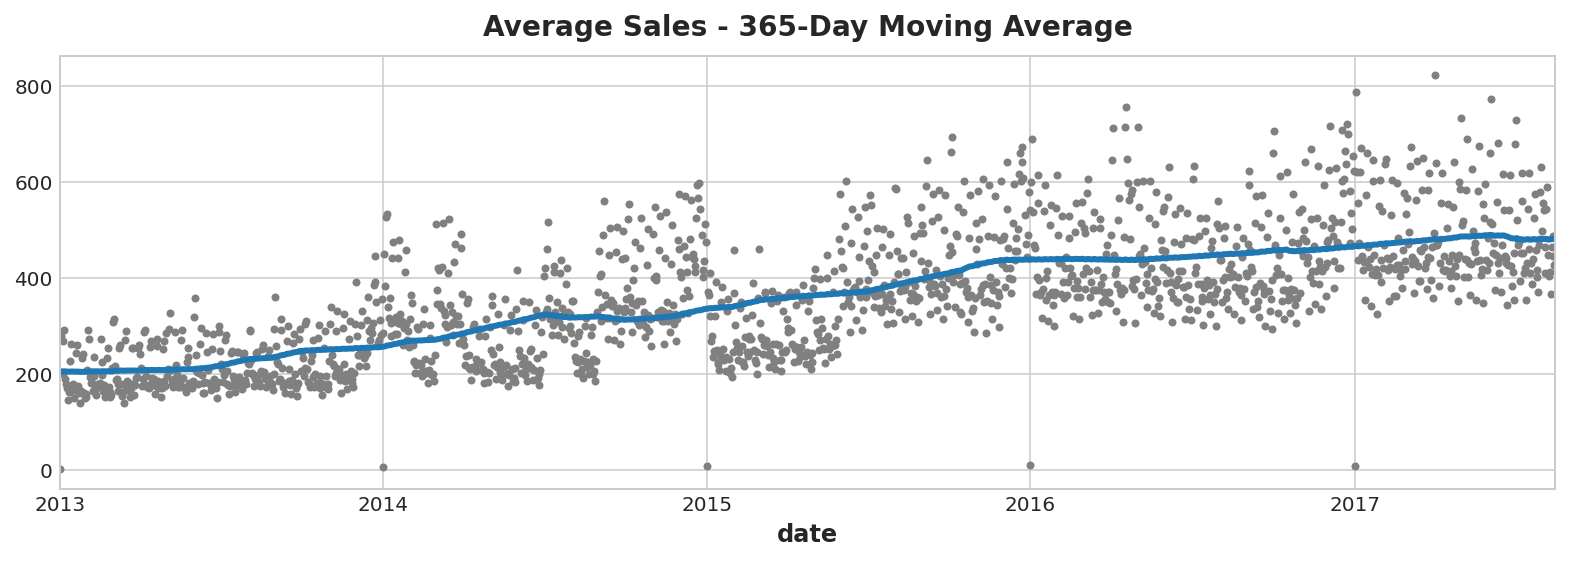

In [29]:
# Moving Average Trend
moving_average = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(style=".", color="0.5")
moving_average.plot(ax=ax, linewidth=3, title="Average Sales - 365-Day Moving Average")

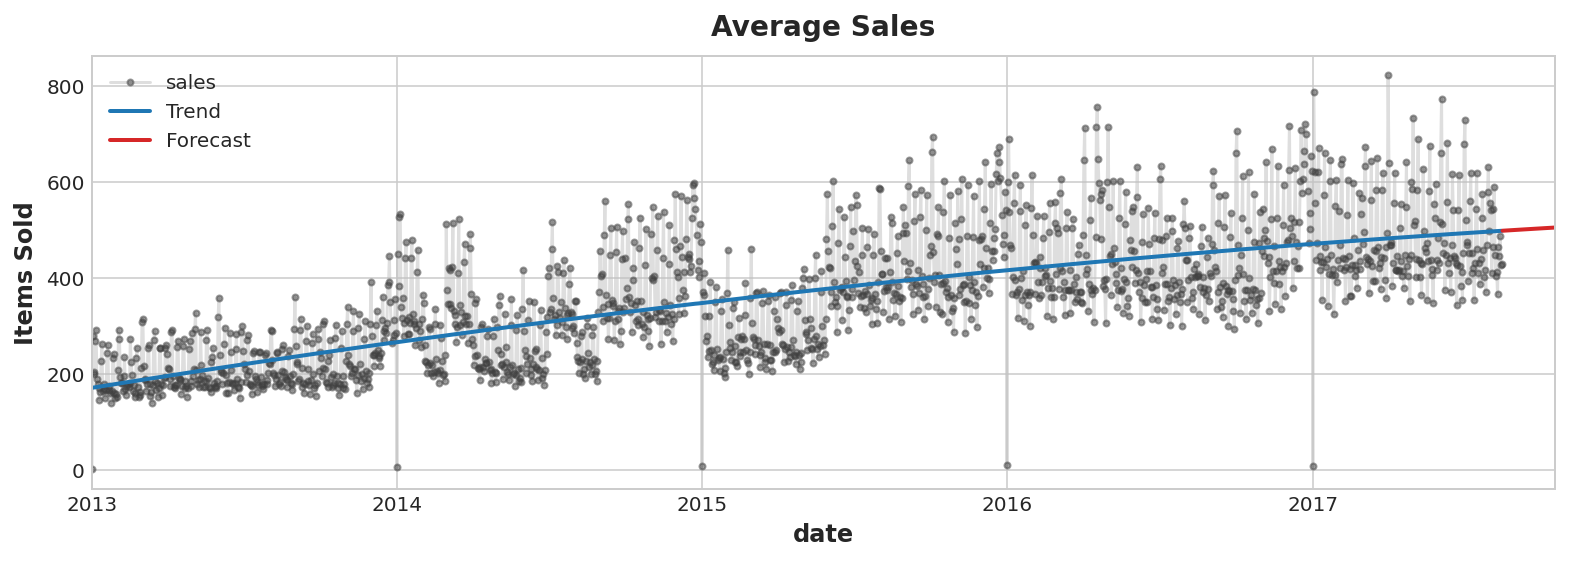

In [30]:
# Average sales polynomial trend and associated forecast

y = average_sales.copy()

dp = DeterministicProcess(
    index=y.index,
    order=2,
)

X = dp.in_sample()
X_fore = dp.out_of_sample(64)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="Items Sold")
ax = y_pred.plot(ax=ax, linewidth=2, label="Trend", color="C0")
ax = y_fore.plot(ax=ax, linewidth=2, label="Forecast", color="C3")
ax.legend()

In [31]:
# Individual stores and categories trend
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]
y.head()

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       2.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       3.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       2.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  659.570007        1243.0         11.0                    41.0   
2017-01-03  547.364014         876.0          6.0                    15.0   
2017-01-04  395.287994         677.0          6.0                    13.0   
2017-01-05  470.768005         604.0          7.0                    10.0   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    0.000000       0.000000     0.000000                        0.0   
2017-01-02  843.596008     115.188995  3136.895996                        1.0   
2017-01-03  714.659973     133.039001  3229.558105                        1.0   
2017-01-04  536.830017      75.201004  1491.416992                        7.0   
2017-01-05  414.100006     113.698997  1566.821045                        1.0   

                    
store_nbr           
family     SEAFOOD  
date                
2017-01-01     0.0  
2017-01-02    23.0  
2017-01-03    14.0  
2017-01-04     0.0  
2017-01-05    17.0  

[5 rows x 1782 columns]

In [33]:
dp = DeterministicProcess(
    index=y.index,
    order=2,
)

X = dp.in_sample()
X_fore = dp.out_of_sample(64)

model = LinearRegression()
model.fit(X, y)

y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [ ]:
# Check against different store numbers and series

In [ ]:
# Seasonal plot by week and year

In [ ]:
# Periodogram

In [ ]:
# Check lags and autocorrelation

In [ ]:
# Calculate residuals

In [ ]:
# Fit residuals